## Notebook Imports

In [2]:
from os import walk
from os.path import join
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## Constantes

In [92]:
ARCHIVO_EJEMPLO = '../SpamData/01_Processing/practice_email.txt'

SPAM1_PATH = '../SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM2_PATH = '../SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM1_PATH = '../SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM2_PATH = '../SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

DATA_JSON_FILE = '../SpamData/01_Processing/email-text-data.json'

WHALE_SHAPE = '../SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_SHAPE = '../SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP_SHAPE = '../SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_SHAPE = '../SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

DATA_TRAIN_FILE = '../SpamData/02_Training/train-data.txt'
DATA_TEST_FILE = '../SpamData/02_Training/test-data.txt'

SPAM_CAT = 1
HAM_CAT = 0

In [4]:
stream = open(ARCHIVO_EJEMPLO)
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
stream = open(ARCHIVO_EJEMPLO)

es_cuerpo = False
lineas = []

for line in stream:
    if es_cuerpo:
        lineas.append(line)
    elif line == '\n':
        es_cuerpo=True


stream.close()

mensaje = '\n'.join(lineas)

print(mensaje)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email body extraction

In [6]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root,file_name)
            
            stream = open(filepath, encoding='latin-1')

            es_cuerpo = False
            lineas = []

            for line in stream:
                if es_cuerpo:
                    lineas.append(line)
                elif line == '\n':
                    es_cuerpo=True
                    
            stream.close()
            mensaje = '\n'.join(lineas)         
            
            yield file_name, mensaje

In [7]:
def df_from_directory(path, classification):
    rows = []
    rows_names = []
    
    for file_name, mensaje in email_body_generator(path):
        rows.append({'MESSAGE': mensaje, 'CATEGORY': classification})
        rows_names.append(file_name)
        
    return pd.DataFrame(rows, index=rows_names)

In [8]:
spam_emails = df_from_directory(SPAM1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM2_PATH,SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [9]:
spam_emails.shape

(1898, 2)

In [10]:
ham_emails = df_from_directory(EASY_NONSPAM1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM2_PATH,HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [11]:
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [13]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [14]:
data["MESSAGE"].isnull().values.any()

False

In [15]:
(data.MESSAGE.str.len()==0).any()

True

In [16]:
data["MESSAGE"].isnull().sum()

0

In [17]:
data[(data.MESSAGE.str.len()==0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [18]:
data.drop(['cmds'],inplace=True)

In [19]:
data.shape

(5796, 2)

In [20]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Document IDs

In [21]:
document_ids = range(0, len(data.index))
data["DOCS_ID"] = document_ids
data["FILENAME"] = data.index

In [22]:
data.set_index("DOCS_ID", inplace=True)

In [23]:
data

,MESSAGE,CATEGORY,FILENAME
DOCS_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


In [24]:
data.tail()

,MESSAGE,CATEGORY,FILENAME
DOCS_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [25]:
data.to_json(DATA_JSON_FILE)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
amounts_spam = data.CATEGORY.value_counts()[1]
amounts_ham = data.CATEGORY.value_counts()[0]

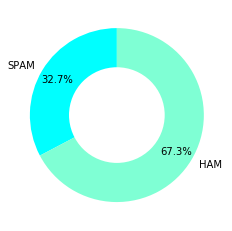

In [28]:
category_names = ["SPAM","HAM"]
sizes = [amounts_spam,amounts_ham]


plt.pie(sizes, labels=category_names, startangle=90, autopct='%1.1f%%',
       colors=["cyan","aquamarine"], pctdistance=0.8)

centre_circle = plt.Circle((0,0),radius=0.55, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

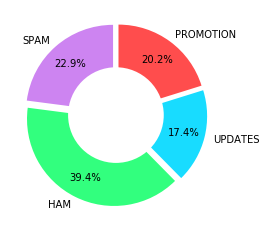

In [29]:
category_names = ["SPAM","HAM","UPDATES","PROMOTION"]
sizes = [25,43,19,22]
offset = [0.05,0.05,0.05,0.05]

plt.pie(sizes, labels=category_names, startangle=90, autopct='%1.1f%%',
       colors=["#cd84f1","#32ff7e","#18dcff","#ff4d4d"], pctdistance=0.75, explode=offset)

centre_circle = plt.Circle((0,0),radius=0.55, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

In [30]:
msg = 'Hello my name is miau'
word_tokenize(msg.lower())

['hello', 'my', 'name', 'is', 'miau']

In [31]:
stop_words = set(stopwords.words('english'))

In [32]:
if 'hello' not in stop_words: print('Not in here')

Not in here


In [33]:
msg = 'All work and no play makes Jack a dull boy'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy']

# Stemming


In [34]:
msg = 'All work and no play makes Jack a dull boy ?'
words = word_tokenize(msg.lower())
stemmer = PorterStemmer()


filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
filtered_words

['work', 'play', 'make', 'jack', 'dull', 'boy']

In [35]:
soup = BeautifulSoup(data.at[2,"MESSAGE"], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [36]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

# Funciones

In [37]:
def clean_message(message, stemmer = PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [38]:
clean_message(mensaje)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [39]:
def clean_message_nhtml(message, stemmer = PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

def clean_message_nhtml_nstem(message, stemmer = PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            #filtered_words.append(stemmer.stem(word))
            filtered_words.append(word)
    
    return filtered_words

In [40]:
clean_message_nhtml(data.at[2,'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Data cleaning para todos los correos

In [41]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILENAME
DOCS_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [42]:
emails_p = data.MESSAGE.iloc[0:3]
nested_list = emails_p.apply(clean_message_nhtml)

In [43]:
nested_list = data.MESSAGE.apply(clean_message_nhtml_nstem)
nested_list_stem = data.MESSAGE.apply(clean_message_nhtml)

c:\users\usuario\appdata\local\programs\python\python36\lib\site-packages\bs4\__init__.py:398: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


In [44]:
nested_list.head()

DOCS_ID
0    [save, life, insurance, spend, life, quote, sa...
1    [fight, risk, cancer, http, slim, guaranteed, ...
2    [fight, risk, cancer, http, slim, guaranteed, ...
3    [adult, club, offers, free, membership, instan...
4    [thought, might, like, slim, guaranteed, lose,...
Name: MESSAGE, dtype: object

In [45]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [46]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [47]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [48]:
spamlist = [st for row in nested_list_spam for st in row]
hamlist = [st for row in nested_list_ham for st in row]


ham_words = pd.Series(hamlist).value_counts()
ham_words.shape[0]

30098

In [49]:
ham_words[:10]

http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
dtype: int64

In [50]:
spam_words = pd.Series(spamlist).value_counts()
spam_words.shape[0]

18022

In [51]:
spam_words[:10]

http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
dtype: int64

# Word Cloud

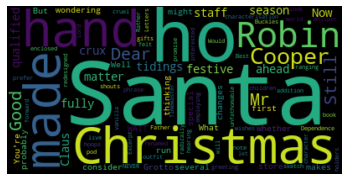

In [52]:
word_cloud = WordCloud().generate(mensaje)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [53]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [54]:
word_list = [''.join(word) for word in example_corpus]
novel_string = ' '.join(word_list)

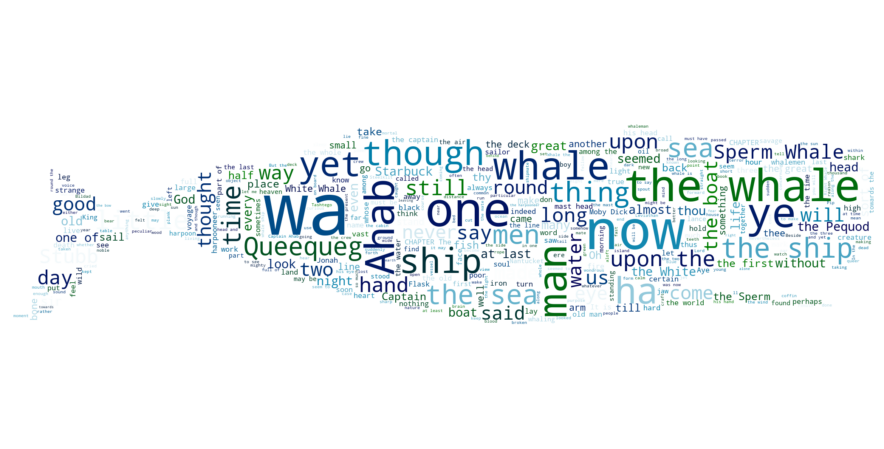

In [55]:
icon = Image.open(WHALE_SHAPE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

plt.figure(figsize=[16,8])
word_cloud = WordCloud(mask=rgb_array, background_color="white", max_words=400, colormap="ocean").generate(novel_string)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [56]:
hamlet_corpus = nltk.corpus.shakespeare.words('hamlet.xml')
hamlet_corpus

['The',
 'Tragedy',
 'of',
 'Hamlet',
 ',',
 'Prince',
 'of',
 'Denmark',
 'Dramatis',
 'Personae',
 'CLAUDIUS',
 ',',
 'king',
 'of',
 'Denmark',
 '.',
 'HAMLET',
 ',',
 'son',
 'to',
 'the',
 'late',
 ',',
 'and',
 'nephew',
 'to',
 'the',
 'present',
 'king',
 '.',
 'POLONIUS',
 ',',
 'lord',
 'chamberlain',
 '.',
 'HORATIO',
 ',',
 'friend',
 'to',
 'Hamlet',
 '.',
 'LAERTES',
 ',',
 'son',
 'to',
 'Polonius',
 '.',
 'LUCIANUS',
 ',',
 'nephew',
 'to',
 'the',
 'king',
 '.',
 'VOLTIMAND',
 'CORNELIUS',
 'ROSENCRANTZ',
 'GUILDENSTERN',
 'OSRIC',
 'courtiers',
 '.',
 'A',
 'Gentleman',
 'A',
 'Priest',
 '.',
 'MARCELLUS',
 'BERNARDO',
 'officers',
 '.',
 'FRANCISCO',
 ',',
 'a',
 'soldier',
 '.',
 'REYNALDO',
 ',',
 'servant',
 'to',
 'Polonius',
 '.',
 'Players',
 '.',
 'Two',
 'Clowns',
 ',',
 'grave',
 '-',
 'diggers',
 '.',
 'FORTINBRAS',
 ',',
 'prince',
 'of',
 'Norway',
 '.',
 'A',
 'Captain',
 '.',
 'English',
 'Ambassadors',
 '.',
 'GERTRUDE',
 ',',
 'queen',
 'of',
 'Denmar

In [57]:
lista = [''.join(word) for word in hamlet_corpus]
novela = ' '.join(lista)
novela

"The Tragedy of Hamlet , Prince of Denmark Dramatis Personae CLAUDIUS , king of Denmark . HAMLET , son to the late , and nephew to the present king . POLONIUS , lord chamberlain . HORATIO , friend to Hamlet . LAERTES , son to Polonius . LUCIANUS , nephew to the king . VOLTIMAND CORNELIUS ROSENCRANTZ GUILDENSTERN OSRIC courtiers . A Gentleman A Priest . MARCELLUS BERNARDO officers . FRANCISCO , a soldier . REYNALDO , servant to Polonius . Players . Two Clowns , grave - diggers . FORTINBRAS , prince of Norway . A Captain . English Ambassadors . GERTRUDE , queen of Denmark , and mother to Hamlet . OPHELIA , daughter to Polonius . Lords , Ladies , Officers , Soldiers , Sailors , Messengers , and other Attendants . Ghost of Hamlet ' s Father . SCENE Denmark . HAMLET ACT I SCENE I . Elsinore . A platform before the castle . FRANCISCO at his post . Enter to him BERNARDO BERNARDO Who ' s there ? FRANCISCO Nay , answer me : stand , and unfold yourself . BERNARDO Long live the king ! FRANCISCO B

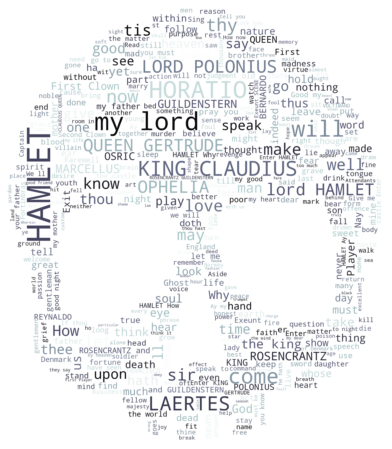

In [58]:
icon = Image.open(SKULL_SHAPE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

plt.figure(figsize=[16,8])
word_cloud = WordCloud(mask=rgb_array, background_color="white", max_words=400, colormap="bone").generate(novela)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Word cloud of ham and spam

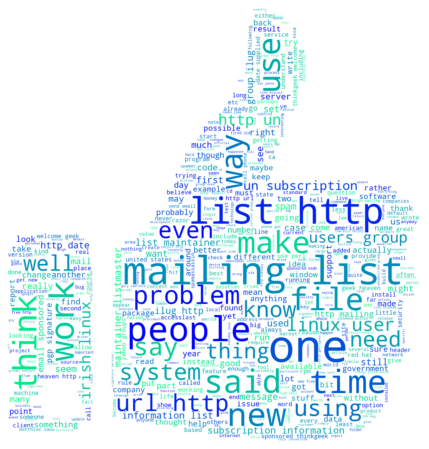

In [59]:
icon = Image.open(THUMBS_UP_SHAPE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

ham_str = ' '.join(hamlist)

plt.figure(figsize=[16,8])
word_cloud = WordCloud(mask=rgb_array, background_color="white",
                       max_words=500, colormap="winter").generate(ham_str)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

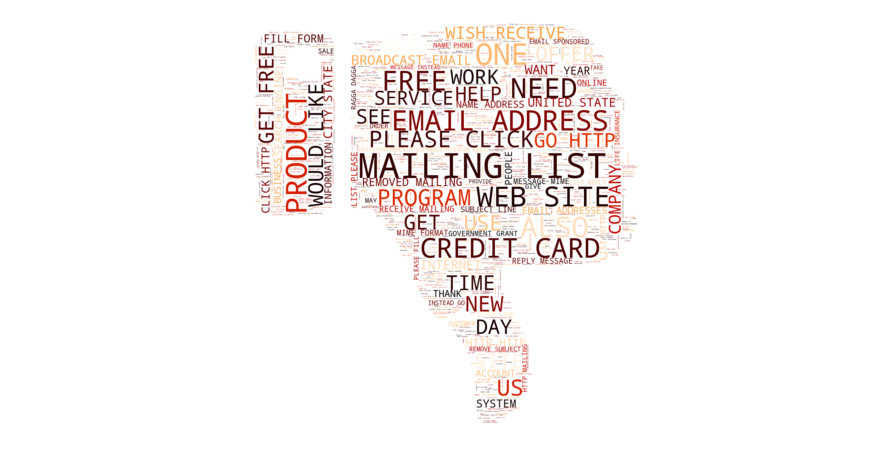

In [60]:
icon = Image.open(THUMBS_DOWN_SHAPE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

ham_str = ' '.join(spamlist)

plt.figure(figsize=[16,8])
word_cloud = WordCloud(mask=rgb_array, background_color="white",
                       max_words=1000, colormap="gist_heat").generate(ham_str.upper())


plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Generate word vocabulary

In [61]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_nhtml)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [62]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [63]:
VOCAB_SIZE=2500
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words.head(10)

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

# Vocabulary Dataframe

In [64]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get
...,...
2495,boom
2496,strateg
2497,transit


In [65]:
def comprobar(word):
    return word in vocab.VOCAB_WORD.values


In [66]:
comprobar('app')

True

In [67]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email: ', max(clean_email_lengths))
print('Position ', np.argmax(clean_email_lengths))

Nr words in the longest email:  7671
Position  5775


In [68]:
stemmed_nested_list[5775]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

# Generate Features y Sparse Matrix

In [69]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

# Splitting data

In [70]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [71]:
print('NR of train samples: ',len(X_train))

NR of train samples:  4057


In [72]:
X_train.index.name = X_test.index.name = "DOC_ID"

In [73]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [74]:
def make_sparse_matrix(df, indexed_words, labels):
    
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

In [75]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [76]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1240
2,0,4844,1,505
3,0,4844,1,308
4,0,4844,1,254


In [77]:
sparse_train_df.shape

(429246, 4)

In [78]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()

In [79]:
train_grouped = train_grouped.reset_index()

# Challenge

In [80]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [81]:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()

In [82]:
test_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2
...,...,...,...,...
117767,5793,2328,0,2
117768,5793,2362,0,1
117769,5793,2382,0,4
117770,5793,2394,0,3


In [83]:
train_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1
...,...,...,...,...
258352,5795,2034,0,1
258353,5795,2039,0,2
258354,5795,2277,0,1
258355,5795,2338,0,1


In [94]:
np.savetxt(DATA_TRAIN_FILE, train_grouped, fmt='%d')
np.savetxt(DATA_TEST_FILE, test_grouped, fmt='%d')

# Pre-Processing

In [93]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID) 

In [85]:
len(train_doc_ids)

4013

In [86]:
len(X_train)

4057

In [87]:
len(test_doc_ids)

1724

In [88]:
len(X_test)

1739